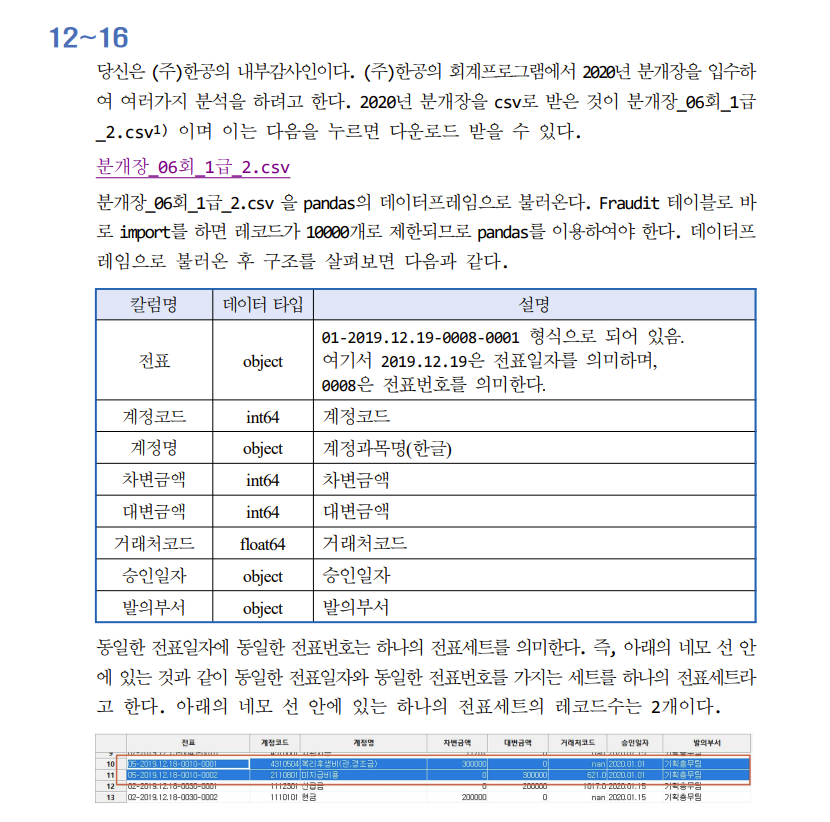

### 문제 12
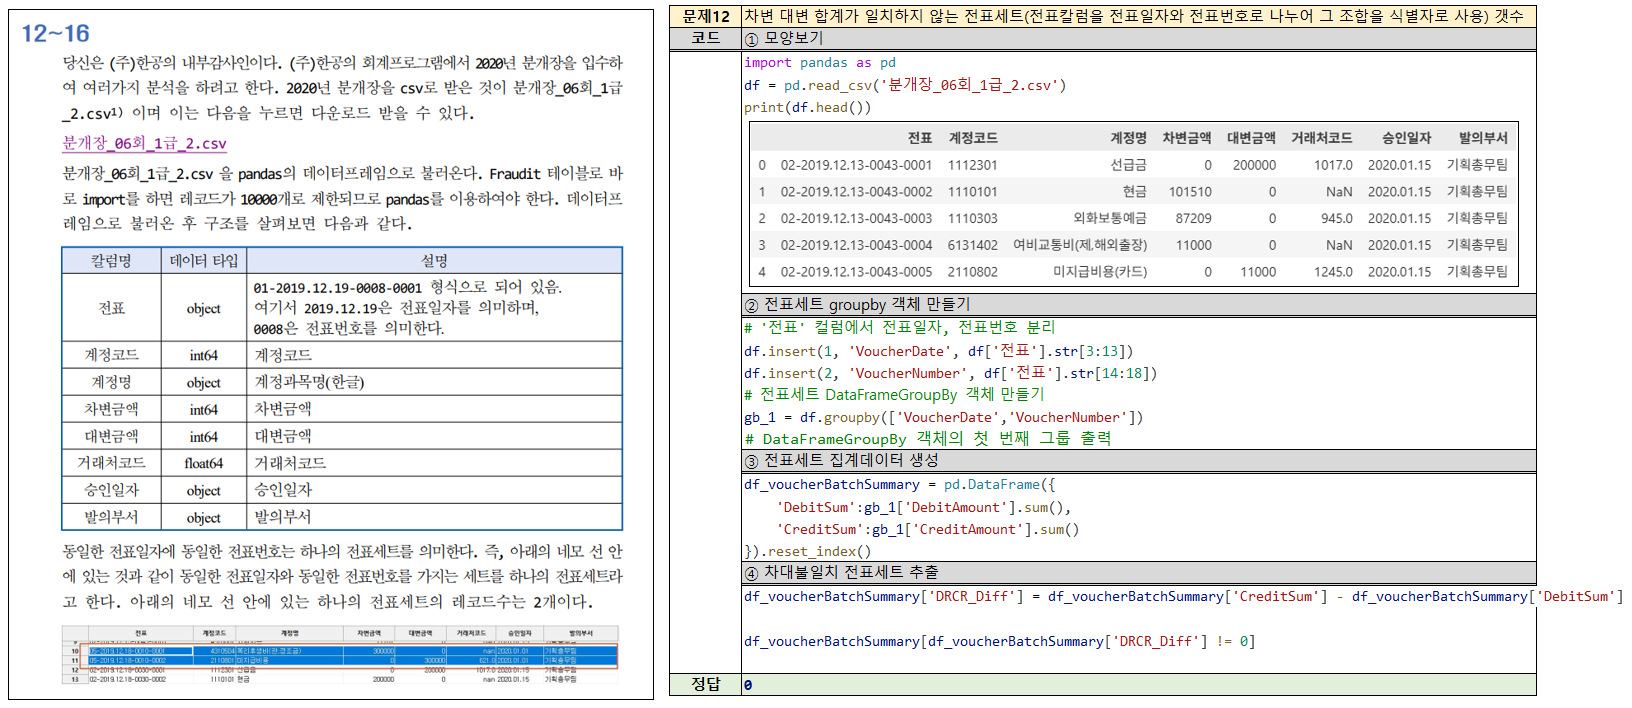

In [3]:
import pandas as pd
df = pd.read_csv('분개장_06회_1급_2.csv')

# '전표' 컬럼에서 전표일자, 전표번호 분리
df.insert(1, 'VoucherDate', df['전표'].str[3:13])
df.insert(2, 'VoucherNumber', df['전표'].str[14:18])

# 전표세트 DataFrameGroupBy 객체 만들기
gb_1 = df.groupby(['VoucherDate','VoucherNumber'])

# 전표세트 집계데이터 생성
df_voucherBatchSummary = pd.DataFrame({
    'DebitSum':gb_1['차변금액'].sum(),
    'CreditSum':gb_1['대변금액'].sum()
}).reset_index()

# 차대불일치 전표세트 추출
df_voucherBatchSummary['DRCR_Diff'] = df_voucherBatchSummary['CreditSum'] - df_voucherBatchSummary['DebitSum']

df_voucherBatchSummary[df_voucherBatchSummary['DRCR_Diff'] != 0]

,VoucherDate,VoucherNumber,DebitSum,CreditSum,DRCR_Diff


### 문제13
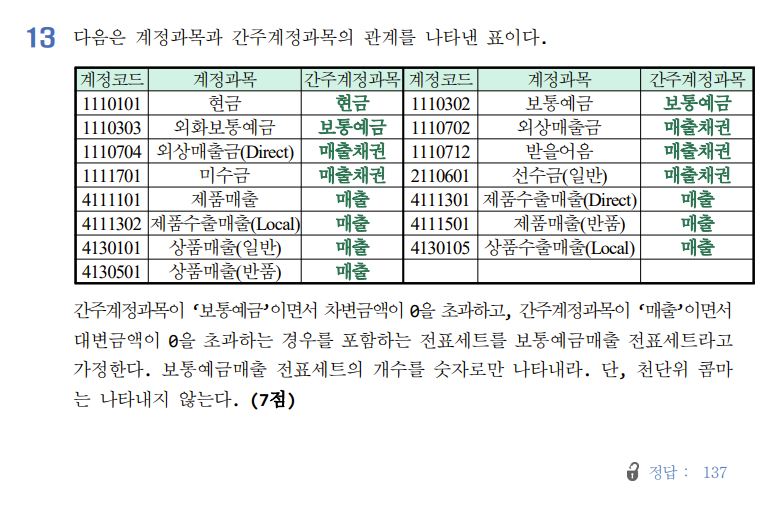

In [6]:
cash_account_list = [1110302, 1110303]
sales_account_list = [4111101, 4111301, 4111302, 4111501, 4130101, 4130105, 4130501]
# 간주계정과목이 '보통예금'이면서 차변금액이 0을 초과하는 행 표시
# 간주계정과목이 '매출'이면서 대변금액이 0을 초과하는 행 표시
df['cash_in_bank_debit_flag'] = ((df['계정코드'].isin(cash_account_list)) & (df['차변금액'] > 0)).astype(int)
df['sales_credit_flag'] = ((df['계정코드'].isin(sales_account_list)) & (df['대변금액'] > 0)).astype(int)

# 전표 단위로 조건 표시
gb_1 = df.groupby(['VoucherDate', 'VoucherNumber'])
df_summary = pd.DataFrame({
    'cash_in_bank_debit_flag': gb_1['cash_in_bank_debit_flag'].sum(),
    'sales_credit_flag': gb_1['sales_credit_flag'].sum()
}).reset_index().reset_index()

# 두 조건 모두 만족하는 경우 출력
df_summary_extract = df_summary[
    (df_summary['cash_in_bank_debit_flag'] > 0) & 
    (df_summary['sales_credit_flag'] > 0)
]
df_summary_extract



,index,VoucherDate,VoucherNumber,cash_in_bank_debit_flag,sales_credit_flag
19,19,2020.01.02,0006,1,1
73,73,2020.01.03,0003,1,1
125,125,2020.01.06,0002,1,1
127,127,2020.01.06,0004,1,1
195,195,2020.01.08,0007,1,1
...,...,...,...,...,...
8834,8834,2020.09.24,0011,1,1
8836,8836,2020.09.24,0013,6,1
8843,8843,2020.09.24,0020,6,1
9000,9000,2020.09.29,0022,2,1


### 문제14
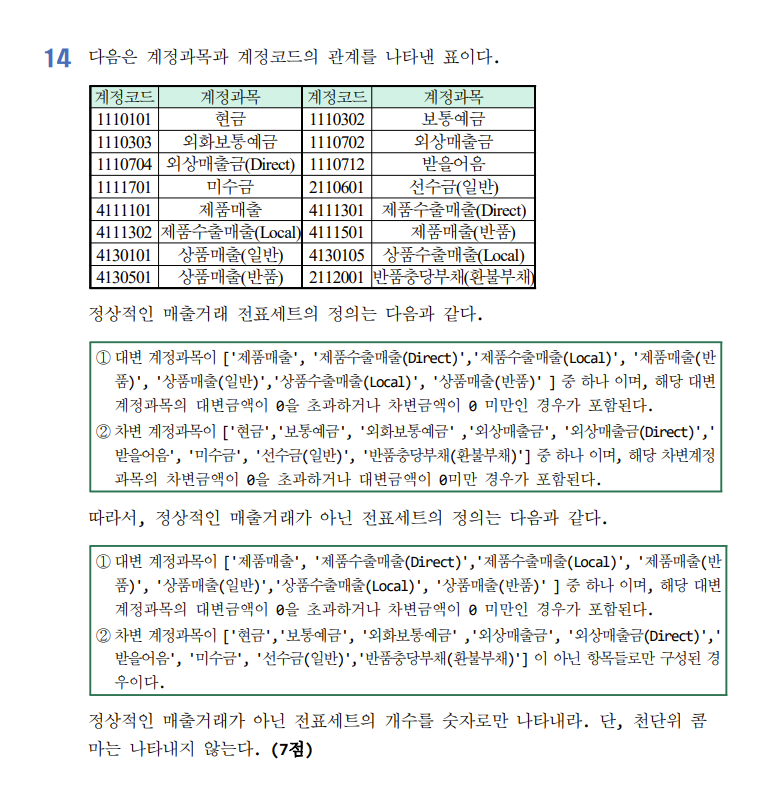

In [10]:
import pandas as pd

sales_account_list = [4111101, 4111301, 4111302, 4111501, 4130101, 4130105, 4130501]
sales_counter_list = [1110101, 1110302, 1110303, 1110702, 1110704, 1110712, 1111701, 2110601, 2112001]

# 정상거래표시
df['sales_account_credit_flag'] = (
     ((df['계정코드'].isin(sales_account_list)) & ((df['대변금액'] > 0) | (df['차변금액'] < 0)))
).astype(int)
df['sales_counter_debit_flag'] = (
    ((df['계정코드'].isin(sales_counter_list)) & ((df['대변금액'] < 0) | (df['차변금액'] > 0)))
).astype(int)


# 전표 단위로 조건 표시
gb_1 = df.groupby(['VoucherDate', 'VoucherNumber'])
df_summary = pd.DataFrame({
    'sales_account_credit_flag': gb_1['sales_account_credit_flag'].sum(),
    'sales_counter_debit_flag': gb_1['sales_counter_debit_flag'].sum()
}).reset_index().reset_index()

# 비정상 조건 만족하는 경우 출력
df_summary[
    (df_summary['sales_account_credit_flag'] > 0) &
    (df_summary['sales_counter_debit_flag'] == 0)
]


,index,VoucherDate,VoucherNumber,sales_account_credit_flag,sales_counter_debit_flag
3238,3238,2020.03.31,0900,1,0
5423,5423,2020.06.06,0900,1,0
6544,6544,2020.07.06,0900,1,0
7464,7464,2020.08.06,0900,1,0
8502,8502,2020.09.08,0900,1,0


### 문제15
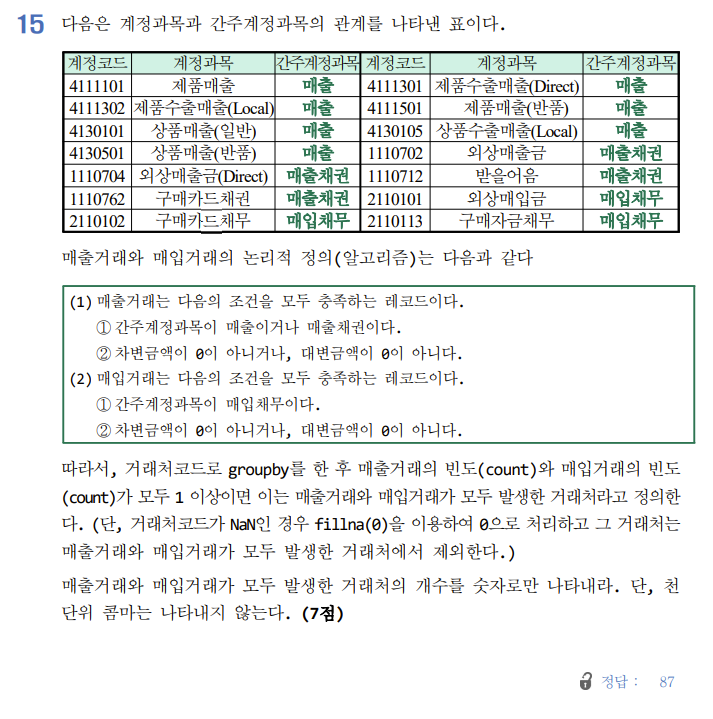

In [14]:
sales_list = [4111101, 4111301, 4111302, 4111501, 4130101, 4130105, 4130501]
accounts_receivable_list = [1110702, 1110704, 1110712, 1110762]
accounts_payable_list = [2110101, 2110102, 2110113]

# 매출거래 row 표시
df['sales_flag'] = (
    (df['계정코드'].isin(sales_list + accounts_receivable_list)) & 
    ((df['차변금액'] != 0) | (df['대변금액'] != 0))
).astype(int)

df['purchase_flag'] = (
    (df['계정코드'].isin(accounts_payable_list)) & 
    ((df['차변금액'] != 0) | (df['대변금액'] != 0))
).astype(int)

# 거래처 NaN 값 제거
df['거래처코드'].fillna(0, inplace=True)

# 거래처 단위로 조건 표시
gb_1 = df.groupby(['거래처코드'])
df_summary = pd.DataFrame({
    'sales_flag': gb_1['sales_flag'].sum(),
    'purchase_flag': gb_1['purchase_flag'].sum()
}).reset_index()

df_summary_extract = df_summary[
    (df_summary['sales_flag'] > 0) & (df_summary['purchase_flag'] > 0)
]

df_summary_extract


,거래처코드,sales_flag,purchase_flag
26,26.0,1,1
39,39.0,21,9
41,41.0,19,15
42,42.0,91,2
55,55.0,4,4
...,...,...,...
1245,1245.0,65,21
1246,1246.0,56,7
1263,1263.0,4,9
1292,1292.0,24,9


### 문제16
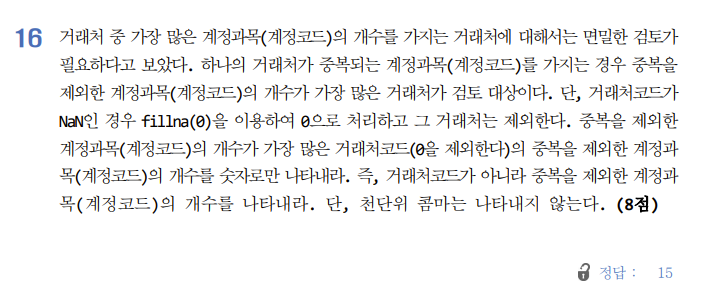

In [15]:
gb_1 = df.groupby(['거래처코드'])

df_summary = pd.DataFrame({
    'unique_account_count': gb_1['계정코드'].nunique()
}).reset_index()


df_summary.sort_values(by='unique_account_count', ascending=False).head(10)

,거래처코드,unique_account_count
0,0.0,202
612,612.0,15
846,846.0,14
1245,1245.0,11
945,945.0,10
836,836.0,9
667,667.0,8
139,139.0,7
759,759.0,7
778,778.0,7


### 문제17
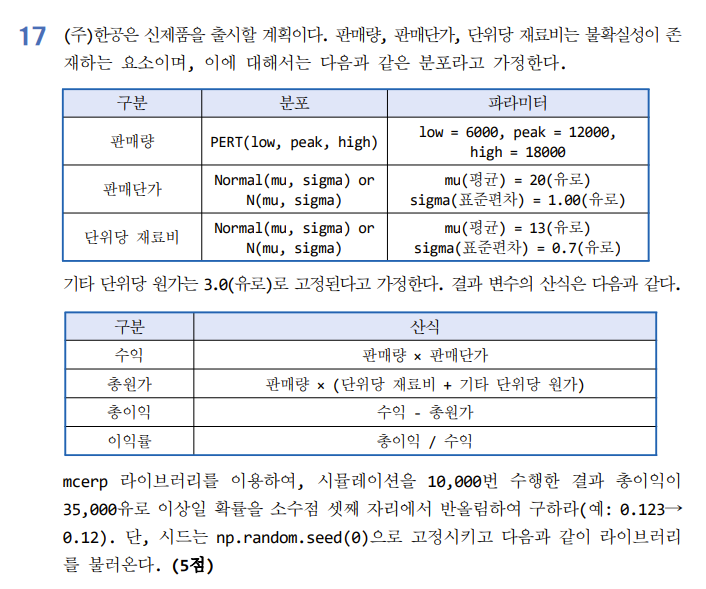

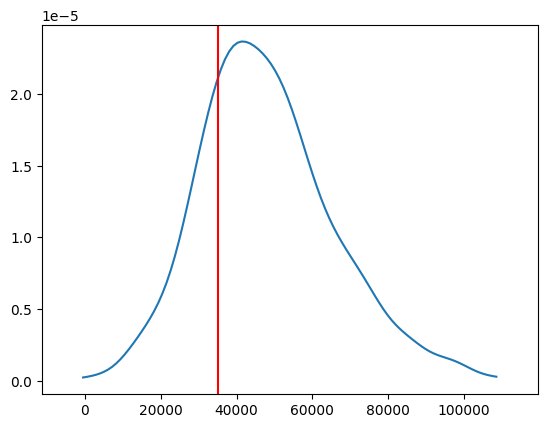

0.773


In [ ]:
import pandas as pd
import numpy as np
import mcerp
from mcerp import *
import matplotlib.pyplot as plt  

# Define conditions
sales_volume_i = PERT(6000, 12000, 18000)   
sales_price_i = N(20, 1.0)                  
unit_material_cost_i = N(13, 0.7)           
other_unit_cost_i = 3.0                     

# Calculate outputs
revenue_o = sales_volume_i * sales_price_i
cost_o = sales_volume_i * (unit_material_cost_i + other_unit_cost_i)
profit_o = revenue_o - cost_o
profit_margin_o = profit_o / revenue_o

# Plot profit distribution
profit_o.plot()
plt.axvline(x=35000, color='r') # axis vertical line
plt.show()

# Probability that profit is greater than 35,000
print(profit_o > 35000)


### 문제18
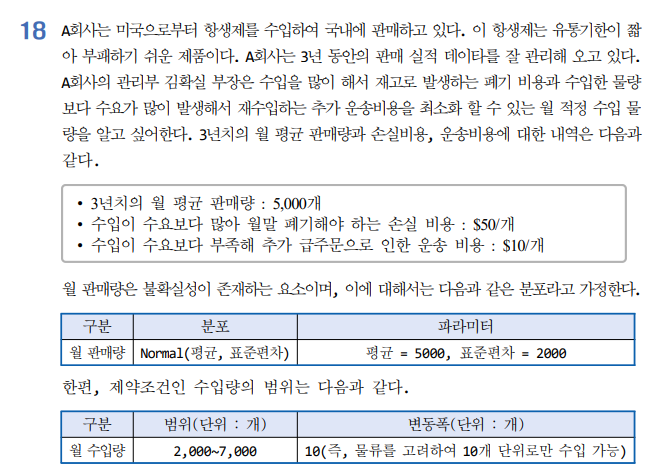
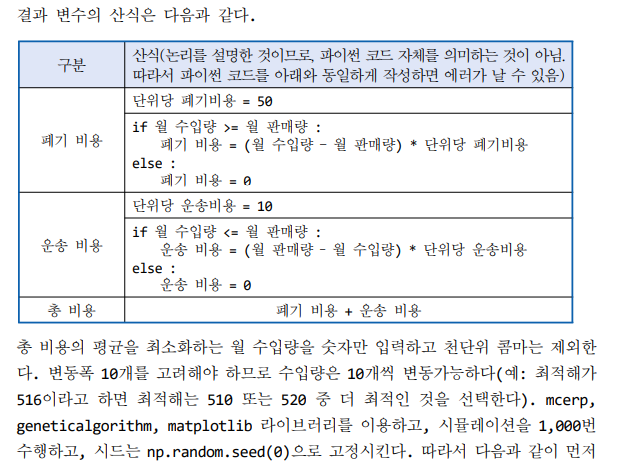
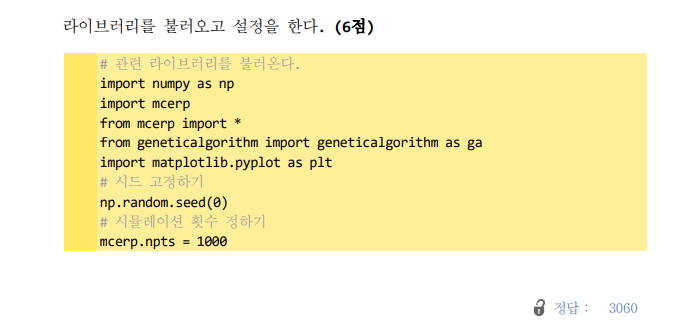

 The best solution found:                                                                           
 [3060.]

 Objective function:
 29960.33561561387


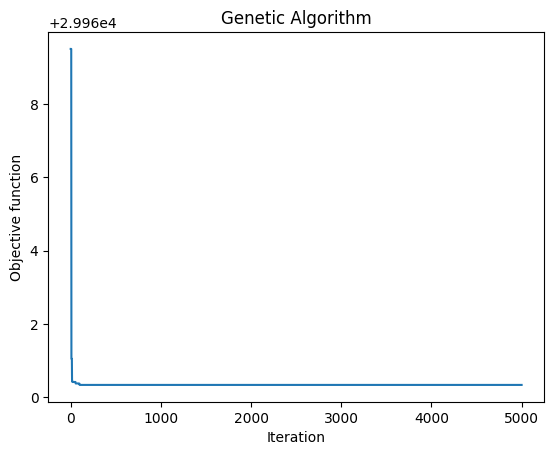

In [ ]:
import numpy as np
import mcerp
from mcerp import *
from geneticalgorithm import geneticalgorithm as ga
import matplotlib.pyplot as plt

# Fix random seed
np.random.seed(0)

# Set the number of simulation points
mcerp.npts = 1000                      # number of simulation points

# Generate monthly sales distribution as an array
monthly_sales = Normal(5000, 2000)
monthly_sales = monthly_sales._mcpts

# Define variable boundaries (constraint)
varbound = np.array([[2000, 7000]])

# Objective function
def f(X):
    global monthly_sales
    monthly_import = X[0]              # Monthly import quantity
    disposal_cost_per_unit = 50
    transport_cost_per_unit = 10

    # Disposal cost occurs when imports exceed sales
    disposal_cost = np.where(
        monthly_import >= monthly_sales,
        disposal_cost_per_unit * (monthly_import - monthly_sales),
        0
    )

    # Transport cost occurs when imports are less than sales
    transport_cost = np.where(
        monthly_import <= monthly_sales,
        transport_cost_per_unit * (monthly_sales - monthly_import),
        0
    )

    total_cost = disposal_cost + transport_cost
    return np.mean(total_cost)

# Run genetic algorithm
model = ga(function=f, dimension=1, variable_type='int', variable_boundaries=varbound)
model.run()


### 문제21
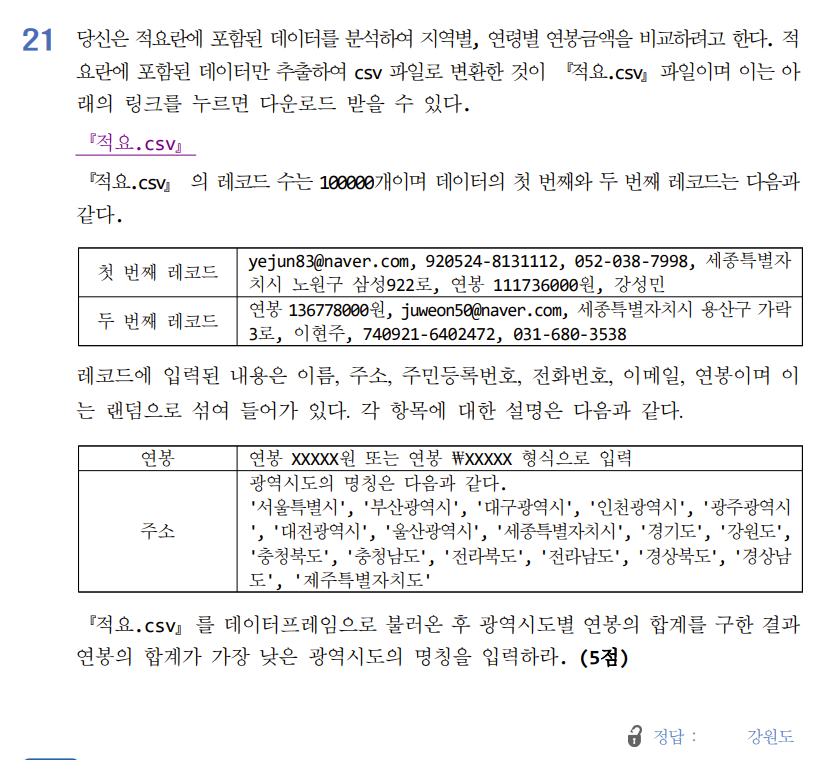

In [102]:
import pandas as pd
import re

df = pd.read_csv('적요.csv')

def extract_sido(text):
    pattern = r'(\w+북도|\w+남도|제주특별자치도|경기도|강원도|세종특별자치시|서울특별시|\w+광역시)'
    match = re.search(pattern, text)
    if match:
        return match.group(1)
    return None

def extract_salary(text):
    pattern = r'연봉\s*\₩*([\d,]*)'
    match = re.search(pattern, text)
    if match:
        return match.group(1)
    return None

df['시도'] = df['적요'].apply(extract_sido)
df['연봉'] = df['적요'].apply(extract_salary).str.replace(',', '').astype('int')

gb_1 = df.groupby(['시도'])

df_요약 = pd.DataFrame({
    '연봉합계': gb_1['연봉'].sum()
}).reset_index()

df_요약.sort_values(by='연봉합계', ascending=True)


,시도,연봉합계
0,강원도,685107434000
3,경상북도,690868608000
15,충청남도,692795639000
16,충청북도,693682537000
1,경기도,697448157000
13,전라북도,697876556000
14,제주특별자치도,699714762000
12,전라남도,713500738000
2,경상남도,713548688000
7,부산광역시,766729030000
